# Evolution de l'émission du centre galactique et de l'émission diffuse

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

Modification du fichier obs-index, qui contient les TSART et les TSTOP en mjd là où gammapy les attends en secondes, 
si on ne fait pas ça (pour ces donnée et la version 0.15), gammapy n'arrive pas à sélectionner les observations voulues, 
car il a ajouté une valeur en mjd comme des secondes à la date de référence pour trouver leur date de début (qui est donc faussée)

In [2]:
from astropy.table import Table 
from gammapy.utils.time import time_relative_to_ref               


table=Table.read("../../../gammapy_data/ash_stereo_Prod17_Calib0834_thsq64/obs-index.fits.gz")

tstart = time_relative_to_ref(Time(table['TSTART_STR'],scale='utc'), table.meta)                                                         

tstop = time_relative_to_ref(Time(table['TSTOP_STR'],scale='utc'), table.meta)                                                          

table['TSTART'][:]=tstart.to('s')                                                                                                       

table['TSTOP'][:]=tstop.to('s')                                                                                                         

table.write("../../../gammapy_data/ash_stereo_Prod17_Calib0834_thsq64/obs-index.fits.gz", overwrite=True)

## Emprunt d'une classe implémentée en 0.16

FoVBackgroundMaker normalise le modèle de fond sur tout le champ de vue

In [2]:
##FoV background estimation
import logging
from gammapy.maps import Map
from gammapy.modeling import Fit, Datasets


class FoVBackgroundMaker:
    """Normalize template background on the whole field-of-view.

    The dataset background model can be simply scaled (method="scale") or fitted (method="fit")
    on the dataset counts.

    The normalization is performed outside the exclusion mask that is passed on init.

    If a SkyModel is set on the input dataset and method is 'fit', its are frozen during
    the fov normalization fit.

    Parameters
    ----------
    method : str in ['fit', 'scale']
        the normalization method to be applied. Default 'scale'.
    exclusion_mask : `~gammapy.maps.WcsNDMap`
        Exclusion mask
    """

    def __init__(self, method="scale", exclusion_mask=None):
        if method in ["fit", "scale"]:
            self.method = method
        else:
            raise ValueError(f"Incorrect method for FoVBackgroundMaker: {method}.")
        self.exclusion_mask = exclusion_mask


    def run(self, dataset):
        """Run FoV background maker.

        Fit the background model norm

        Parameters
        ----------
        dataset : `~gammapy.cube.fit.MapDataset`
            Input map dataset.

        """
        mask_fit = dataset.mask_fit
        dataset.mask_fit = self._reproject_exclusion_mask(dataset)

        if self.method is "fit":
            self._fit_bkg(dataset)
        else:
            self._scale_bkg(dataset)

        dataset.mask_fit = mask_fit
        return dataset


    def _reproject_exclusion_mask(self, dataset):
        """Reproject the exclusion on the dataset geometry"""
        mask_map = Map.from_geom(dataset.counts.geom)
        if self.exclusion_mask is not None:
            coords = dataset.counts.geom.get_coord()
            vals = self.exclusion_mask.get_by_coord(coords)
            mask_map.data += vals

        return mask_map.data.astype("bool")

    def _fit_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""

        # freeze all model components not related to background model
        datasets = Datasets([dataset])

        parameters_frozen = []
        for par in datasets.parameters:
            parameters_frozen.append(par.frozen)
            if par not in dataset.background_model.parameters:
                par.frozen = True

        #!!!AL: relax titlt : BE CARREFULL !!!
        dataset.background_model.tilt.frozen=False
        
        fit = Fit(datasets)
        fit_result = fit.run()
        if fit_result.success is False:
            print("FoVBackgroundMaker failed. No fit convergence")
            

        # Unfreeze parameters
        for i, par in enumerate(datasets.parameters):
            par.frozen = parameters_frozen[i]

    def _scale_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""
        mask = dataset.mask
        count_tot = dataset.counts.data[mask].sum()
        bkg_tot = dataset.background_model.map.data[mask].sum()

        if count_tot <= 0.0:
            print("FoVBackgroundMaker failed. No counts found outside exclusion mask")
        elif bkg_tot <= 0.0:
            print("FoVBackgroundMaker failed. No positive background found outside exclusion mask")
        else:
            scale = count_tot / bkg_tot
            dataset.background_model.norm.value = scale
            #print("bkg scale = ",scale)

## Fabrication des mapdatasets

Define which data to use and print some information

pour la production hap-fr ash : ash_stereo_Prod17_Calib0834_thsq64

pour la production hap-fr he : he_stereo_Prod17_Calib0834_thsq64

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

# faire attention aux fichiers hdu-index et obs-index sur lequel le datastore pointe

Data store:
HDU index table:
BASE_DIR: /home/samuel/code/gammapy_data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 127056
OBS_ID: 18092 -- 154591
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 21186



In [4]:
# Ici on choisit la région du ciel dans laquelle on sélectionne nos observations (en fonction des directions d'observation)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(1.5, 'deg'),
                 border=Angle(0, 'deg'))


# on veut sélectionner les observations avec un angle zénithal suffisamment petit (valeur "neutre" = 70 ou 80 deg)
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=Angle([0., 40.], 'deg'))

obs_table = data_store.obs_table.select_observations(selection)
obs_table = obs_table.select_observations(selectionZEN)

In [5]:
# ces objets permettent de faire la sélection des observations années par années


t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

Sélection par année et tri des observations (on retire celles qui n'ont pas toutes les IRF : surface efficace, dispersion en énergie, PSF et modèle de fond)

In [6]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    
    for obs in observations_year:
        try:
            obs.aeff
            obs.edisp
            obs.psf
            obs.bkg
            
        except:
            ids.remove(obs.obs_id)
            print("Observation retirée : " + str(obs.obs_id))
            
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year

Observation retirée : 31578
Observation retirée : 31579
Observation retirée : 31580
Observation retirée : 129467
Observation retirée : 129471
Observation retirée : 153792
Observation retirée : 146971
Observation retirée : 151790
Observation retirée : 153030
Observation retirée : 153031
Observation retirée : 153791
Observation retirée : 153793
Observation retirée : 153810
Observation retirée : 153811
Observation retirée : 153812
Observation retirée : 153813
Observation retirée : 153836
Observation retirée : 153837
Observation retirée : 153838
Observation retirée : 153839


## Création de la géométrie

Les bornes en énergie reconstruites utilisées sont 500 GeV à 100 TeV, avec 20 bins.
Pour les énergies vraies on est entre 300 GeV et 200 TeV, avec 30 bins.

Pour la région du ciel, on se centre sur (l,b)=(0,0), 10 deg en longitude et 8 en latitude.

In [7]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

# peut être passer à plus que 20 bins en énergie vraie ?

In [8]:
# on créer les objet mapdataset en les rangeant dans un dictionnaire, pour accéder facilement chaque année.
# on précise l'axe utilisé pour les énergies vraies

mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

## Fabrication des mapdatasets

Région d'exclusion pour le FoVBackgroundMaker : un rectangle de 3 deg de longitude sur 1 en latitude
Pour obtenir le masque d'exclusion c'est un peu plus subtil, il faut créer une région dont l'intérieur est False (le rectangle) et l'extérieur est True

Pour le safe mask : on choisit la méthode "offset-max", et la méthode bkg-peak
Pour le FoVBackgroundMaker : on prend la méthode "scale" (fit est également possible)

"bkg-peak" applique automatiquement un masque sur les énergies inférieures à l'énergie où le modèle de fond atteint un pic.
Il est possible de faire cette méthode pour voir quel seuil on a en général, puis manuellement définir le bin suivant comme le nouveau seuil
L'importance de cette méthode est aussi de voir si cette méthode donne à peu près toujours le même résultat où si certaines observations admettent des seuils plus haut, et en quel proportion.

### Graphes "de contrôle" : 
pour évaluer à quel point x ou y effet dû aux instruments influe sur les observations (année par année), on va vouloir extraire plusieurs infos des observation :
- les énergies de seuils (via bkg-peak) pour chaque observation
- les offsets par rapport à la source au centre pour chaque observation (ou bien évènements par évènements ?), dans le premier cas c'est simple et ça se déduit simplement de l'offset max pris en compte et de la direction d'observation
- les azimuts de la source au centre (idem on peut le faire pour chaque observation ou pour chaque évènement).
- coeff de transparence

Les offsets/azimuts pour le diffus sont moins intéressant car de toutes façons il est observé à plein d'offsets/azimuts différents. (2016 nous montre que les observations "bizarres" n'altèrent pas beaucoup le flux du diffus par rapport aux années précédentes).

In [9]:
%%time

exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

histo = dict()

for year in range(2004,2020):
    
    offset_max = 1.8 * u.deg #on peut le réduire pour ne pas prendre les obs trop éloignées du centre de 2.0 deg à 1.8 deg
    maker = MapDatasetMaker()
    maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak"], offset_max=offset_max)
    maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)
    
    histo[year] = []
    
    # au lieu de "scale" prendre "fit" en donnant au dataset un masque sur les bin en énergie (prendre à partir de 1 TeV par ex, même si c'est déjà haut 500 GeV)
    
    # ou alors on met "bkg-peak" pour le safemaskmaker (le premier bin en énergie est retiré)
    
    spectrum = PowerLaw2SpectralModel(index=2.3)

    for obs in yearly_obs[year]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)
        
        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)
        
        
        # pour faire un histogramme des énergies de seuil pour chaque observation
        #centre = dataset.mask_safe.data[:, 100,100]
        #i = np.where(centre == False, 1,0).sum() # +1
        #histo[year].append(energy_axis.edges[i].value)
        
        dataset = maker_bkg.run(dataset)
        
        # The resulting dataset cutout is stacked onto the final one
        mapdataset_dict[year].stack(dataset)


CPU times: user 13min 4s, sys: 2.45 s, total: 13min 7s
Wall time: 13min 8s


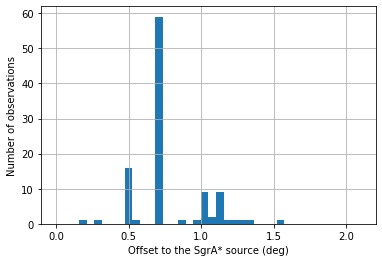

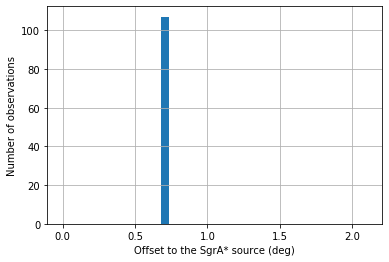

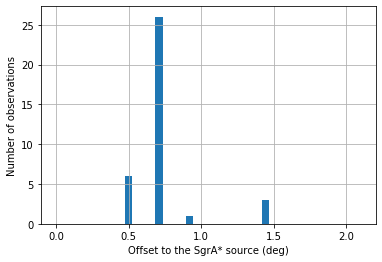

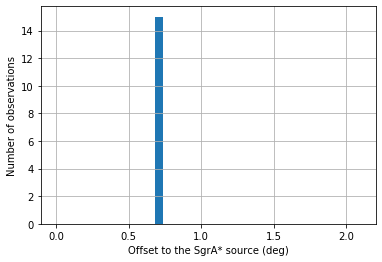

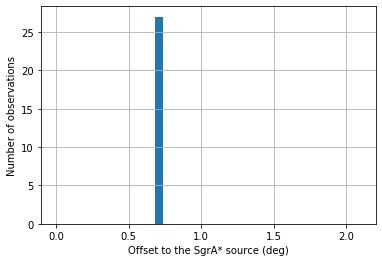

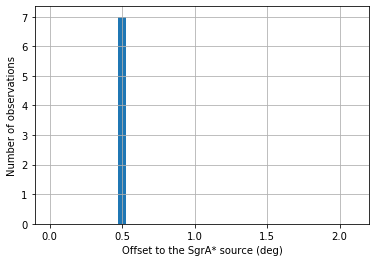

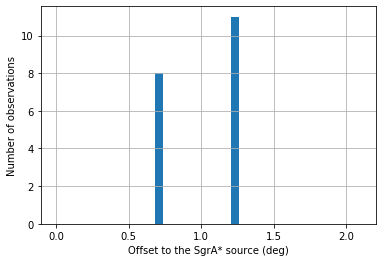

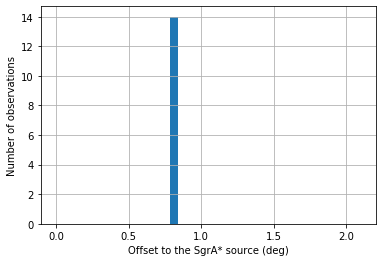

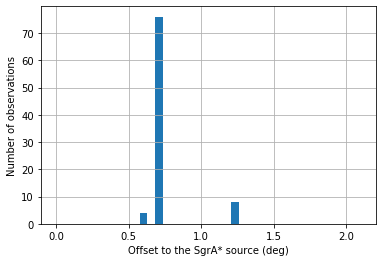

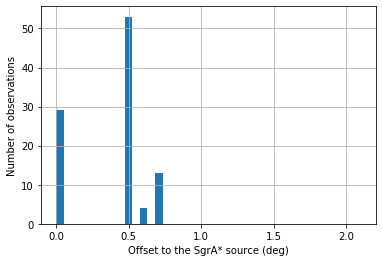

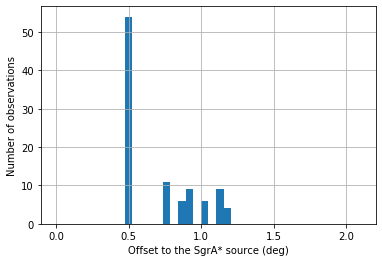

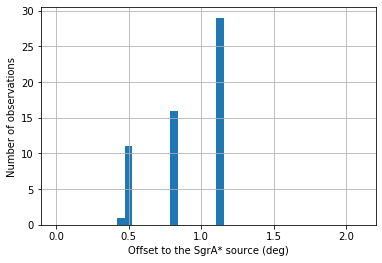

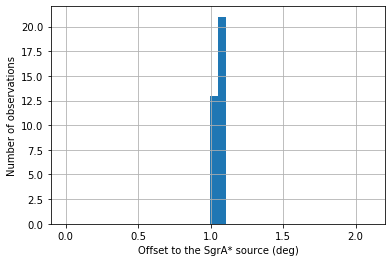

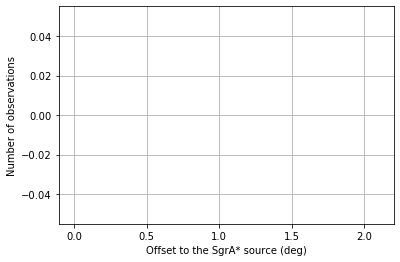

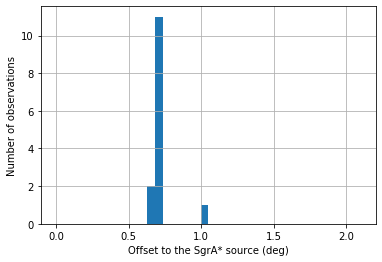

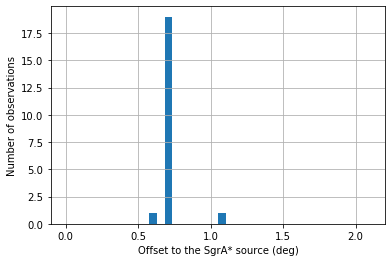

In [10]:
# on extrait les offsets à la source centrale et les azimuts observation par observation

sgra_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

histo_offset = dict()

for year in range(2004,2020):
    histo_offset[year] = []

    for obs in yearly_obs[year]:
        direction = obs.pointing_radec
        sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
        histo_offset[year].append(sep.value)
        
    plt.figure()
    plt.hist(histo_offset[year], 40, (0.0, 2.1))
    
    plt.grid()
    plt.xlabel("Décalage angulaire par rapport à la source (deg)")
    plt.ylabel("Nombre d'observations")
    
    #plt.savefig("offsets_"+str(year)+".pdf", overwrite=True)

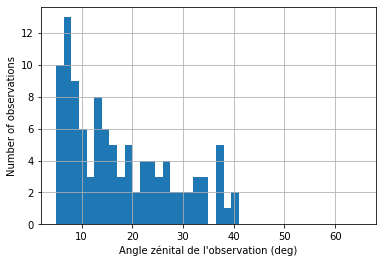

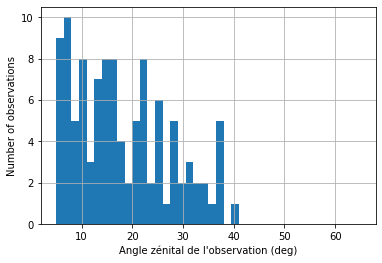

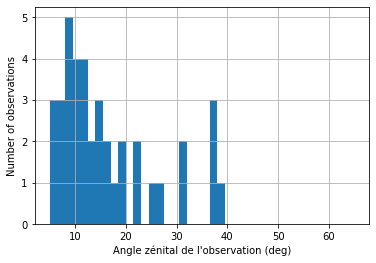

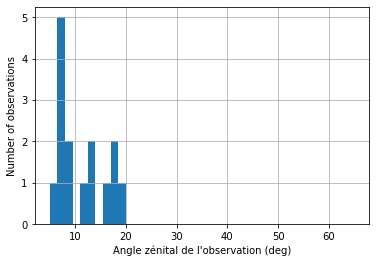

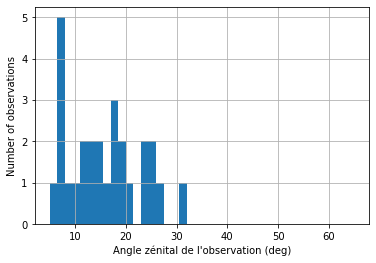

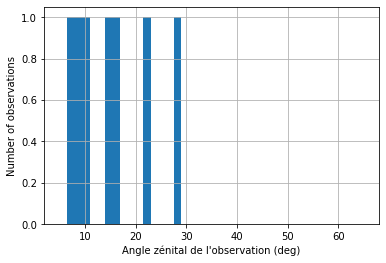

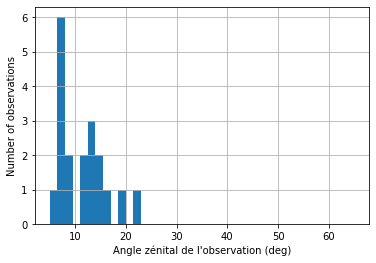

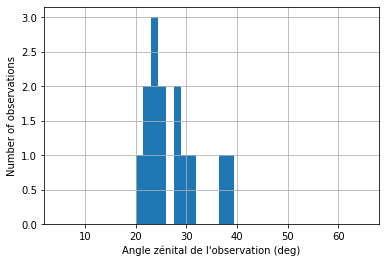

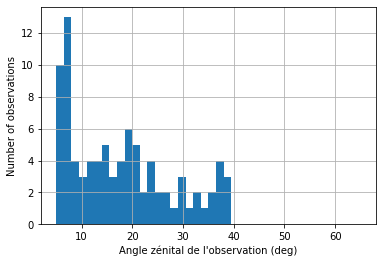

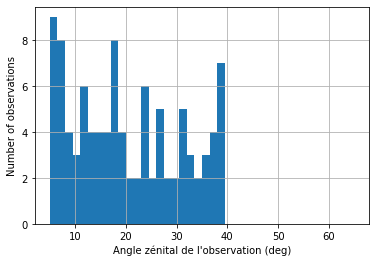

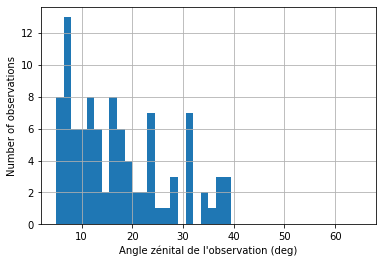

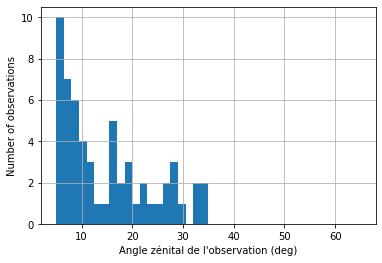

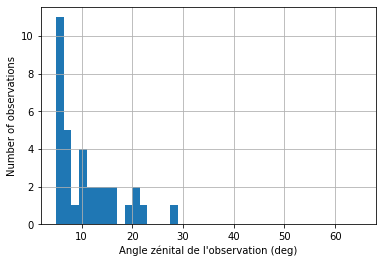

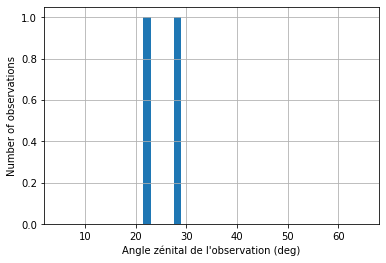

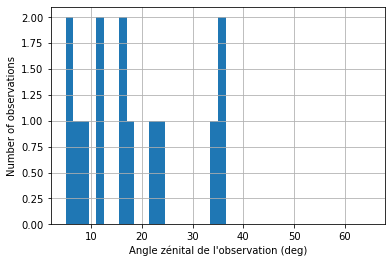

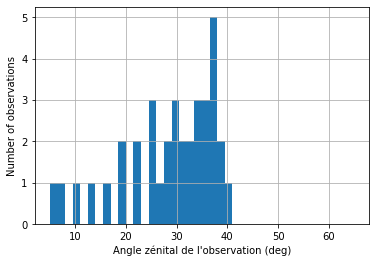

In [11]:
# création des historgrammes d'angles zénithaux de chaque obs, année par année

histo_zen = dict()

for year in range(2004,2020):  
    histo_zen[year] = []
    # les angles zénitaux sont juste stockés dans obs_table
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    histo_zen[year] = obs_table_year["ZEN_PNT"].tolist()
    
    plt.figure()
    plt.hist(histo_zen[year], 40, (5.0, 65.0))
    
    plt.grid()
    plt.xlabel("Angle zénithal de l'observation (deg)")
    plt.ylabel("Nombre d'observations")
    
    #plt.savefig("angzen_"+str(year)+".pdf", overwrite=True)

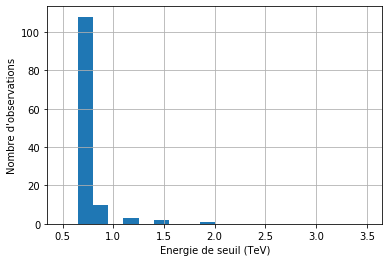

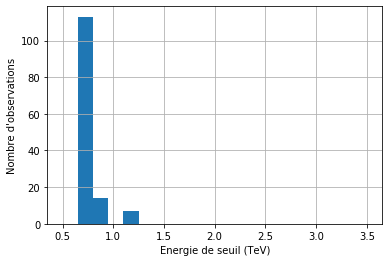

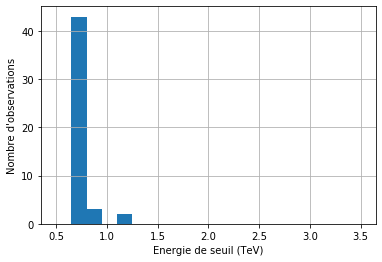

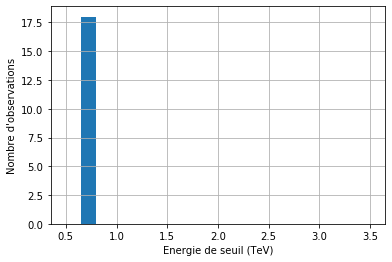

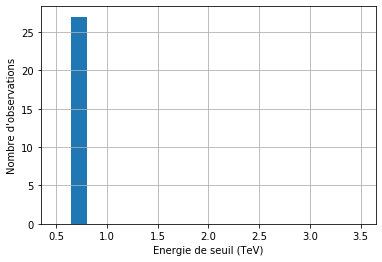

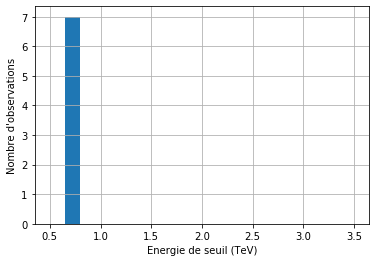

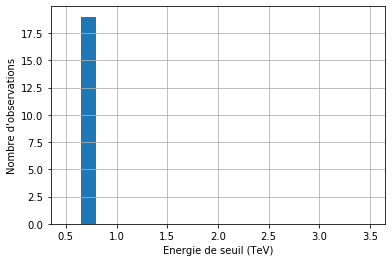

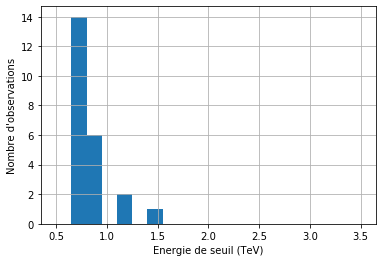

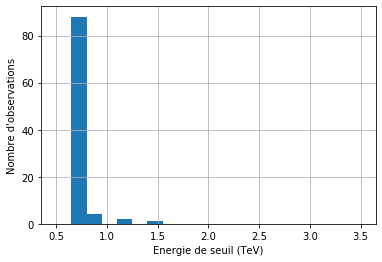

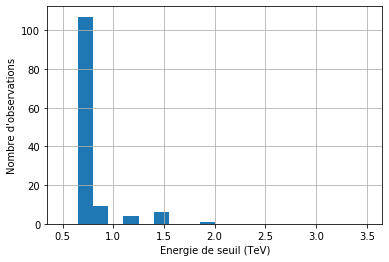

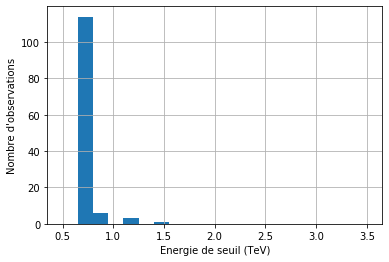

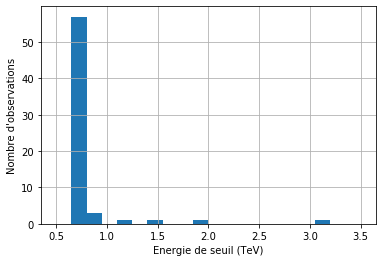

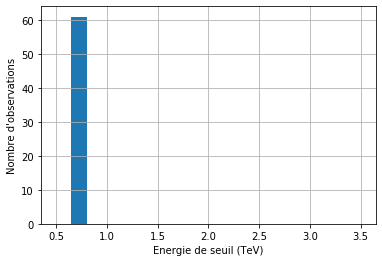

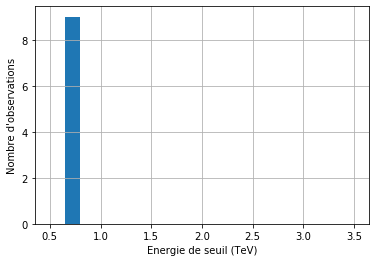

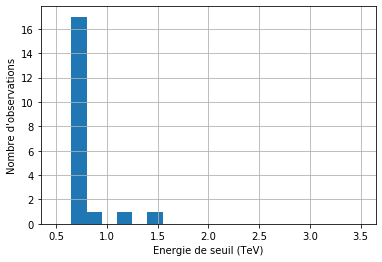

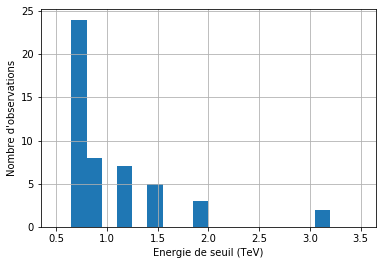

In [94]:
# affichage des histogrammes des énergies de seuil obtenu par bkg-peak, année par année

for year in range(2004,2020):
    
    plt.figure()
    plt.hist(histo[year], 20, (0.5, 3.5))
    
    plt.grid()
    plt.xlabel("Energie de seuil (TeV)")
    plt.ylabel("Nombre d'observations")
    
    plt.savefig("eseuils_"+str(year)+".pdf", overwrite=True)

### Pour information, différentes fonctions et méthodes utilisées ici

In [55]:
# Pour information, la fonction associée à 'bkg-peak', rien à changer a priori, c'est simple et clair. ça fait ce que c'est censé faire, 
# à la limite on peut penser à d'autres méthodes pour couper en énergie

def make_mask_energy_bkg_peak(dataset):
        """Make safe energy mask based on the binned background.

        The energy threshold is defined as the upper edge of the energy
        bin with the highest predicted background rate. This method is motivated
        by its use in the HESS DL3 validation paper: https://arxiv.org/pdf/1910.08088.pdf

        Parameters
        ----------
        dataset : `~gammapy.modeling.Dataset`
            Dataset to compute mask for.

        Returns
        -------
        mask_safe : `~numpy.ndarray`
            Safe data range mask.
        """

        if isinstance(dataset, (MapDataset, MapDatasetOnOff)):
            background_spectrum = dataset.background_model.map.get_spectrum()
            counts = dataset.counts.geom
        else:
            background_spectrum = dataset.background
            counts = dataset.counts

        idx = np.argmax(background_spectrum.data)         # trouve l'indice du max du spectre du bkg
        e_min = background_spectrum.energy.edges[idx + 1] # identifie l'emin comme l'énergie suivante du max
        return counts.energy_mask(emin=e_min)

In [ ]:
# Pour information, la méthode 'stack' de la classe MapDataset, on a un mapdataset (self) auquel on en rajoute un autre (other)

def stack(self, other):
        """Stack another dataset in place.

        Parameters
        ----------
        other: `~gammapy.cube.MapDataset`
            Map dataset to be stacked with this one.
        """

        if self.counts and other.counts:
            self.counts *= self.mask_safe
            self.counts.stack(other.counts, weights=other.mask_safe)

        if self.exposure and other.exposure:                                     # ICI
            mask_image = self.mask_safe.reduce_over_axes(func=np.logical_or)
            self.exposure *= mask_image.data
            
            # TODO: apply energy dependent mask to exposure. Does this require
            #  a mask_safe in true energy?
            
            mask_image_other = other.mask_safe.reduce_over_axes(func=np.logical_or)
            self.exposure.stack(other.exposure, weights=mask_image_other)
            
            # on applique reduce_over_axes aux deux safe_mask, donc on les réduit sur les axes non-spatiaux 
            # (mais on prend le meilleur masque si les énergies sont masquées différemment)
            # donc on ne prend pas en compte le masquage éventuel en énergie lorsqu'on modifie l'exposure, 
            # dans : self.exposure *= mask_image.data (elle est multipliée d'un bloc)
            
            # derrière il semble avoir un souci entre énergie vraie et énergie recombinée
            
            # On finit avec la fonction stack de WcsNDMap, 
            # avec des weights qui RAJOUTENT le nouveau masque 
            # (s'il est plus grand, on supprime de nouveaux bins, s'il est plus petit, les bins effacés le restent), logique avec le concept de 'stack'
            # la question est de savoir si appliquer un masque energie dépendant sur la carte d'exposition nécessite un mask safe en énergie vraie
            # 
            
        if self.background_model and other.background_model:    
            bkg = self.background_model.evaluate()
            bkg *= self.mask_safe
            other_bkg = other.background_model.evaluate()
            bkg.stack(other_bkg, weights=other.mask_safe)

            self.background_model = BackgroundModel(
                bkg, name=self.background_model.name
            )

        if self.mask_safe is not None and other.mask_safe is not None:            # ICI en fait non ya rien à changer ici
            self.mask_safe.stack(other.mask_safe)
            
            # juste une fonction 'stack' celle de WcsNDMap

        if self.psf and other.psf:
            if isinstance(self.psf, PSFMap) and isinstance(other.psf, PSFMap):
                mask_irf = self._mask_safe_irf(self.psf.psf_map, mask_image)
                self.psf.psf_map *= mask_irf.data
                self.psf.exposure_map *= mask_irf.data

                mask_image_other = other.mask_safe.reduce_over_axes(func=np.logical_or)
                mask_irf_other = self._mask_safe_irf(
                    other.psf.psf_map, mask_image_other
                )
                self.psf.stack(other.psf, weights=mask_irf_other)
            else:
                raise ValueError("Stacking of PSF kernels not supported")

        if self.edisp and other.edisp:
            if isinstance(self.edisp, EDispMap) and isinstance(other.edisp, EDispMap):
                mask_irf = self._mask_safe_irf(self.edisp.edisp_map, mask_image)
                self.edisp.edisp_map *= mask_irf.data
                self.edisp.exposure_map *= mask_irf.data

                mask_image_other = other.mask_safe.reduce_over_axes(func=np.logical_or)
                mask_irf_other = self._mask_safe_irf(
                    other.edisp.edisp_map, mask_image_other
                )
                self.edisp.stack(other.edisp, weights=mask_irf_other)
            else:
                raise ValueError("Stacking of edisp kernels not supported")

        if self.gti and other.gti:
            self.gti = self.gti.stack(other.gti).union()

In [ ]:
# Au sujet de l'énergie vraie : elle n'intervient que dans la fonction create où elle est donnée, et permet de créer les cubes pour l'exposition, la psf et l'edisp

geom_image = geom.to_image() # on prend la geom 3d on a passe en 2d pour la repasser en 3d avec l'axe d'énergie vraie
geom_exposure = geom_image.to_cube([energy_axis_true])
geom_irf = geom_image.to_binsz(binsz=binsz_irf) # ça on y touche pas apparemment
geom_psf = geom_irf.to_cube([rad_axis, energy_axis_true])
geom_edisp = geom_irf.to_cube([migra_axis, energy_axis_true])

In [56]:
# Conversion d'un masque en énergie recombinée en un masque en énergie vraie
# sachant qu'a priori on veut pas masquer d'emblée toutes les énergies vraies en dessous du seuil en énergie recombinée
# ça risque d'être lourd
# on peut faire une execption si on a le même nombre de bins pour les deux

def conv_mask_true(mask, erec, etrue):
    # mask est une carte WcsNDMap de booléens
    # erec et etrue sont des energy axis avec des edges et nbins a priori différents
    
    mask_true = mask.copy()
    
    # besoin d'une fonction qui pour un pixel regarde le dernièr bin en énergie rec masqué, et associe une liste de bin en énergie vraie masquée adéquatement

In [ ]:
# Pour info, méthode stack de la classe WcsNDMap

def stack(self, other, weights=None):
        """Stack cutout into map.

        Parameters
        ----------
        other : `WcsNDMap`
            Other map to stack
        weights : `WcsNDMap`
            Array to be used as weights.
        """
        if self.geom == other.geom:
            parent_slices, cutout_slices = None, None
        elif self.geom.is_aligned(other.geom):
            slices = other.geom.cutout_info["parent-slices"]
            parent_slices = Ellipsis, slices[0], slices[1]

            slices = other.geom.cutout_info["cutout-slices"]
            cutout_slices = Ellipsis, slices[0], slices[1]
        else:
            raise ValueError(
                "Can only stack equivalent maps or cutout of the same map."
            )

        data = other.data[cutout_slices]

        if weights is not None:
            data = data * weights.data

        self.data[parent_slices] += data

In [75]:
# A revoir
# Vérification du masque en énergie dans le mapdataset final (avec toutes les observations stackées), 
# il dépend a priori des coordonnées spatiales choisi pour vérifier

mapdataset_dict[2004].mask_safe.data[:,250,250]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [73]:
# simple vérification

print(energy_axis.edges)

[  0.5          0.65166066   0.84932323   1.10694108   1.44269991
   1.88030155   2.45063709   3.19396757   4.16276604   5.42542173
   7.07106781   9.21587344  12.01124434  15.65451083  20.40285773
  26.59147948  34.65724216  45.16952262  58.87040187  76.7270499
 100.        ] TeV


In [ ]:
# Pour masquer plus de bins que ce que fait le mask safe

mask = dataset.mask_safe.copy()
mask.data[0:3,:,:]=False
dataset.mask_fit = mask

Sauvegarde des mapdatasets

In [12]:
for year in range(2004,2020):
    
    filename = "../../../gammapy_data/mapdataset_hess/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year].write(filename, overwrite=True)